In [1]:
from sunpy.net import Fido, attrs as a
from sunpy.time import TimeRange
import sunpy.timeseries as ts
from sunpy.map import Map
from sunpy.net.vso import VSOClient
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from scipy.signal import find_peaks
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.table import Table
from astropy.io import fits
import astropy.units as u
import pickle
import glob
import cdflib
from cdflib import cdfepoch
import pywt
from scipy.interpolate import LSQUnivariateSpline
from scipy.interpolate import UnivariateSpline

In [2]:
tr = TimeRange("2015-11-04 13:30:00", "2015-11-04 14:00:00") # our time range, for now!

### 1. EUV light curves from SDO/AIA

---

#### Those were used to analyze the most prominent pulsations in the EUV regime. We work with the

#### $17.1\,\rm nm$ (dominated by Fe II line, emission from corona and upper transition region) and

#### $160.0\,\rm nm$ (dominated by C IV, emission from upper photosphere) passbands. 

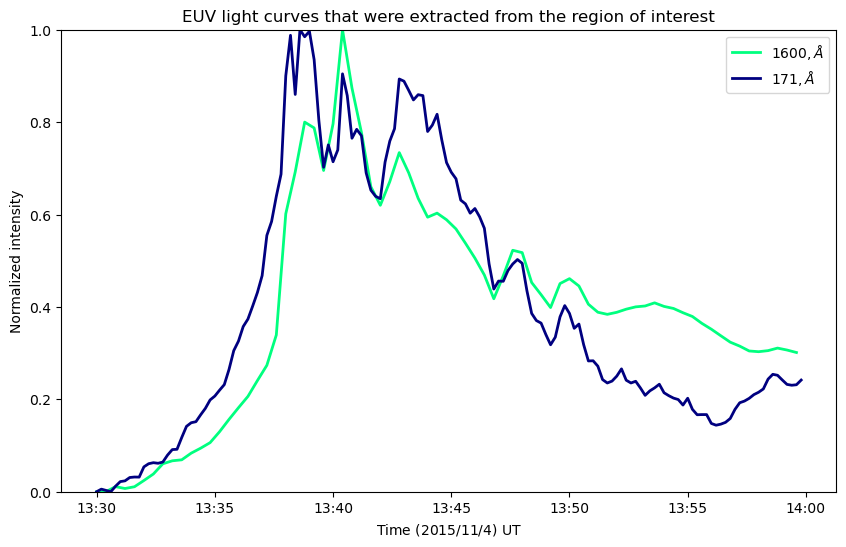

In [74]:
aia171 = pd.read_pickle('norm171.pkl') # these light curves were preprocessed and normalized
aia1600 = pd.read_pickle('norm1600.pkl')
offset = 0.2
aia171 = aia171-offset

aia171_nm = (aia171 - aia171.min()) / (aia171.max() - aia171.min())
aia1600_nm = (aia1600 - aia1600.min()) / (aia1600.max() - aia1600.min())

plt.figure(figsize=(10,6))
plt.plot(aia1600_nm.index, aia1600_nm, c='springgreen', lw=2, label=r'$1600,\AA$')
plt.plot(aia171_nm.index, aia171_nm, c='navy', lw=2, label=r'$171,\AA$')

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))

plt.ylim(0,1)
plt.xlabel(r'Time $(2015/11/4)$ UT')
plt.ylabel('Normalized intensity')
plt.title(r'EUV light curves that were extracted from the region of interest')
plt.legend()
plt.show()

### 2. Soft X-ray (SXR) and Hard X-ray (HXR) light curves from GOES and Fermi GBM

---

Here, we have solar SXR fluxes integrated over the entire solar disk. Cadence equals to $2s$ 

with two channels of $0.05-0.4\,\rm nm$ and $0.1-0.8\,\rm nm$. We focus on the $0.1-0.8\,\rm nm$ channel.

Furthemore, we use HXR light curve observed by the Fermi GBM ($25–50\,\rm keV$). We also show

the Neupert effect (with the derivative of SXR light curve from above) and phases of the flare.

In [4]:
res = Fido.search(a.Time(tr.start, tr.end), a.Instrument('XRS'),
                  a.goes.SatelliteNumber(15), a.Resolution("flx1s"))

In [5]:
files = Fido.fetch(res)
goes = ts.TimeSeries(files)

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

We do some plots for check!

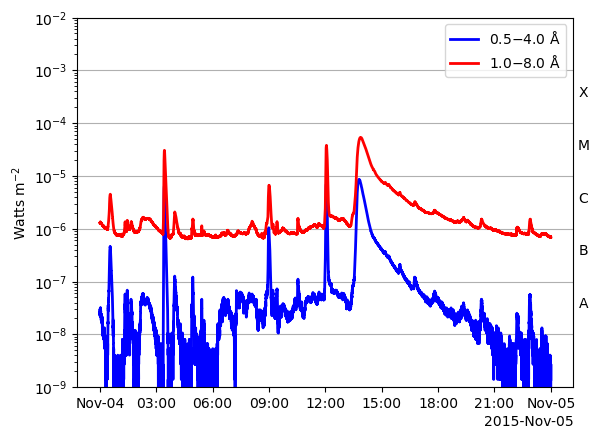

In [6]:
fig, ax = plt.subplots()
goes.plot(axes=ax)
plt.show()

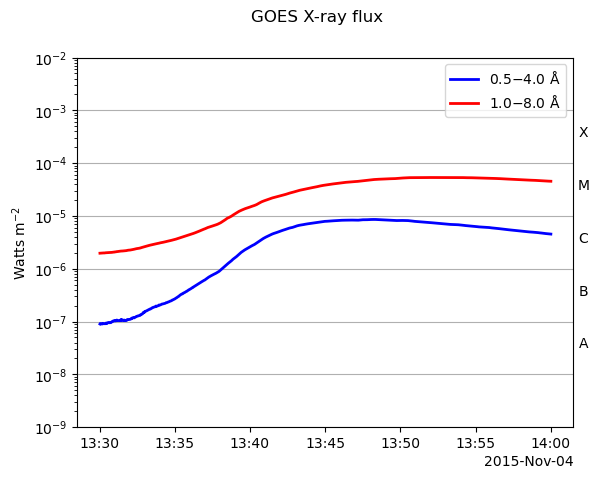

In [7]:
tstart = "2015-11-04T13:30"
tend = "2015-11-04T14:00"
goes_slice = goes.truncate(tstart, tend)
goes_slice.peek()

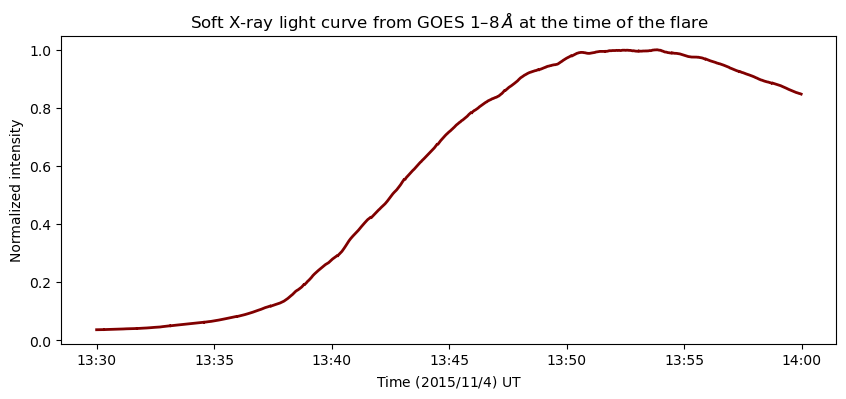

In [8]:
goes_df = goes_slice.to_dataframe()
goes_df = goes_df.resample('2s').mean()
intensity      = goes_df['xrsb']
norm_intensity = intensity / intensity.max()
# norm_intensity = (intensity - intensity.min()) / (intensity.max() - intensity.min())

plt.figure(figsize=(10,4))
plt.plot(norm_intensity.index, norm_intensity, c='maroon', lw=2)

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))

plt.xlabel(r'Time $(2015/11/4)$ UT')
plt.ylabel('Normalized intensity')
plt.title(r'Soft X-ray light curve from GOES $1–8\,\AA$ at the time of the flare')
plt.show()

Here, we have our approximation of the flare phases.

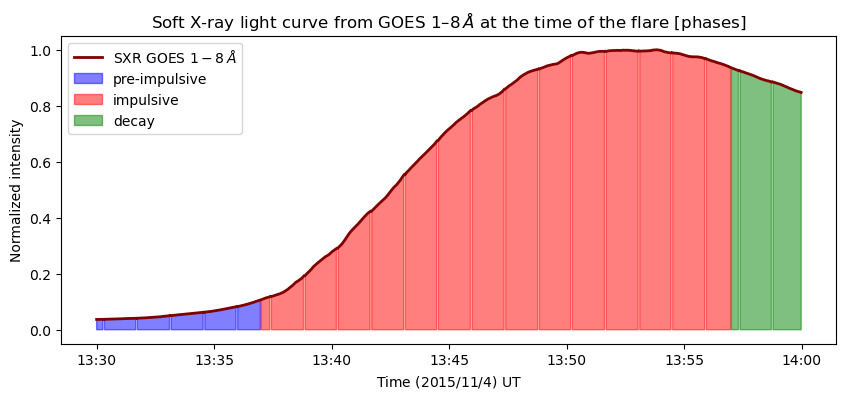

In [9]:
tpre_start = "2015-11-04 13:30"
tpre_end = "2015-11-04 13:37"
timp_end = "2015-11-04 13:57"
tend = "2015-11-04 14:00"

mask_pre = (norm_intensity.index >= tpre_start) & (norm_intensity.index <  tpre_end)
mask_imp = (norm_intensity.index >= tpre_end)   & (norm_intensity.index <  timp_end)
mask_decay = (norm_intensity.index >= timp_end)   & (norm_intensity.index <= tend)

plt.figure(figsize=(10,4))
plt.plot(norm_intensity.index, norm_intensity, c='maroon', lw=2, label=r'SXR GOES $1-8\,\AA$')  

plt.fill_between(norm_intensity.index[mask_pre], norm_intensity[mask_pre],
                 color='blue',  alpha=0.5, label='pre‐impulsive')
plt.fill_between(norm_intensity.index[mask_imp], norm_intensity[mask_imp],
                 color='red', alpha=0.5, label='impulsive')
plt.fill_between(norm_intensity.index[mask_decay], norm_intensity[mask_decay],
                 color='green',   alpha=0.5, label='decay')

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))

plt.xlabel(r'Time $(2015/11/4)$ UT')
plt.ylabel('Normalized intensity')
plt.title(r'Soft X-ray light curve from GOES $1–8\,\AA$ at the time of the flare [phases]')
plt.legend(loc='upper left')
plt.show()

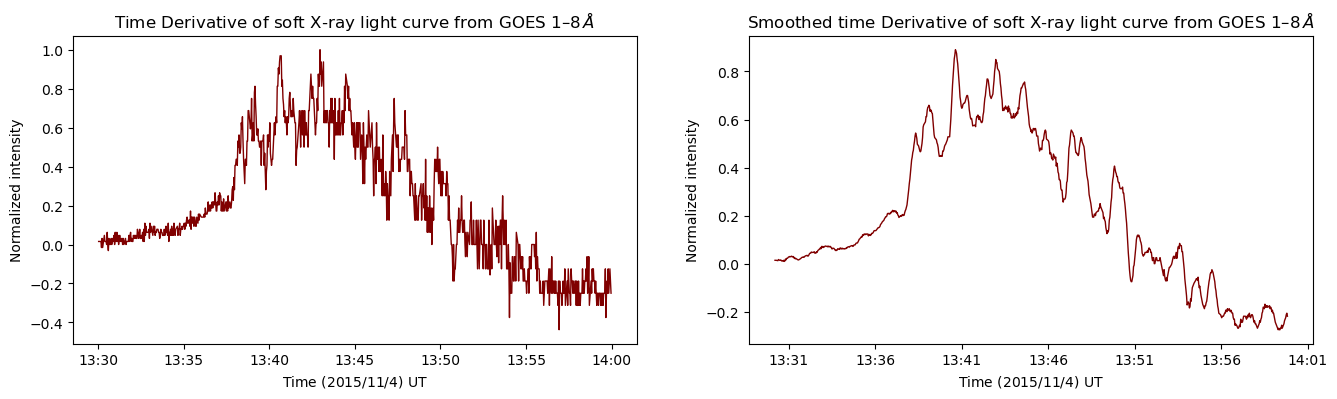

In [10]:
dt = norm_intensity.index.to_series().diff().dt.total_seconds()
dint_dt = norm_intensity.diff()/dt
dint_dt = dint_dt.dropna()
dint_dt_norm = dint_dt / dint_dt.max()
# dint_dt_norm = (dint_dt - dint_dt.min())/(dint_dt.max() - dint_dt.min())

smooth_window = int(20 / 2)  # smoothing
smooth_goes_derv = dint_dt_norm.rolling(window=smooth_window, center=True).mean().dropna()

plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(dint_dt_norm, c='maroon', lw=1)
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
plt.xlabel(r'Time $(2015/11/4)$ UT')
plt.ylabel('Normalized intensity')
plt.title(r'Time Derivative of soft X-ray light curve from GOES $1–8\,\AA$')

plt.subplot(122)
plt.plot(smooth_goes_derv, c='maroon', lw=1)

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))

plt.xlabel(r'Time $(2015/11/4)$ UT')
plt.ylabel('Normalized intensity')
plt.title(r'Smoothed time Derivative of soft X-ray light curve from GOES $1–8\,\AA$')
plt.show()

We pay attention to the GBM HXR dataset.

In [11]:
tr = TimeRange("2015-11-04 13:30:00", "2015-11-04 14:00:00")
res = Fido.search(a.Time(tr.start, tr.end), a.Instrument('GBM'), 
                  a.Source('FERMI'), a.Physobs('flux'))

In [12]:
files = Fido.fetch(res)
gbm = ts.TimeSeries(files, concatenate=True)
# we have error because of some zero‐exposure intervals, but that's not important

Files Downloaded:   0%|          | 0/20 [00:00<?, ?file/s]

/home/zorzeus/anaconda3/envs/sunpy/lib/python3.12/site-packages/sunpy/timeseries/sources/fermi_gbm.py:227: RuntimeWarning: invalid value encountered in divide
  summary_counts.append(summed_counts/energy_width/count_data["exposure"])


---

There is some jitter in the HXR curve (it will be visible on the plot bellow). This probably comes

from instrumental and photon‐count noise and that can affect detrending procedure we should perform.

In [13]:
gbm_df = gbm.to_dataframe()
gbm_df = gbm_df.truncate(tstart, tend)
gbm_df = gbm_df['25-50 keV']
gbm_r = gbm_df.resample('1600ms').mean().dropna()

dt = gbm_r.index.to_series().diff().dt.total_seconds().dropna()
print("Check: new median delta t (s)= ", dt.median())

norm_gbm = gbm_r /gbm_r.max()
# norm_gbm = (gbm_r - gbm_r.min()) / (gbm_r.max() - gbm_r.min())

smooth_window = int(5 / 1.6)  # smoothing
smooth_gbm = norm_gbm.rolling(window=smooth_window, center=True).mean().dropna()

Check: new median delta t (s)=  1.6


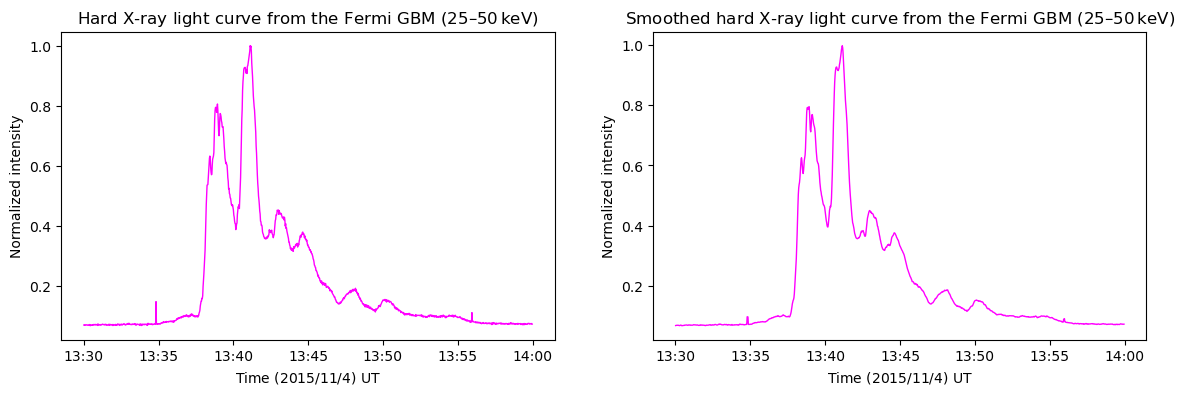

In [14]:
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.plot(norm_gbm.index, norm_gbm, c='magenta', lw=1)

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))

plt.xlabel(r'Time $(2015/11/4)$ UT')
plt.ylabel('Normalized intensity')
plt.title(r'Hard X-ray light curve from the Fermi GBM ($25–50\,\rm keV$)')

plt.subplot(122)
plt.plot(smooth_gbm.index, smooth_gbm, c='magenta', lw=1)

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))

plt.xlabel(r'Time $(2015/11/4)$ UT')
plt.ylabel('Normalized intensity')
plt.title(r'Smoothed hard X-ray light curve from the Fermi GBM ($25–50\,\rm keV$)')

plt.show()

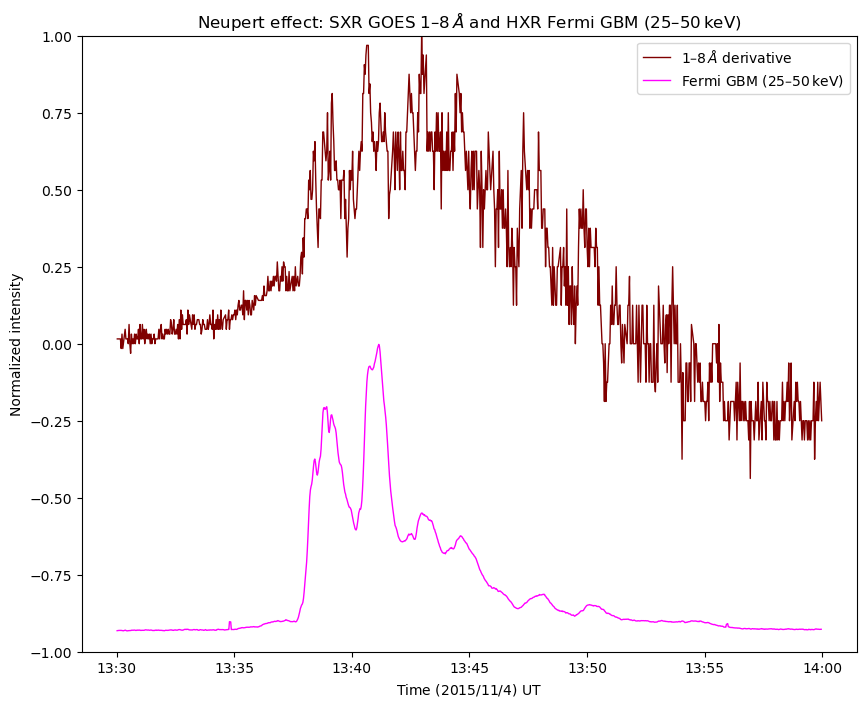

In [15]:
offset = 1
gbm = smooth_gbm - offset

plt.figure(figsize=(10,8))
plt.plot(dint_dt_norm.index, dint_dt_norm, c='maroon', lw=1, label=r'$1–8\,\AA$ derivative')
plt.plot(gbm.index, gbm, c='magenta', lw=1, label=r'Fermi GBM ($25–50\,\rm keV$)')

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))

plt.ylim(-1, 1)
plt.xlabel(r'Time $(2015/11/4)$ UT')
plt.ylabel('Normalized intensity')
plt.title(r'Neupert effect: SXR GOES $1–8\,\AA$ and HXR Fermi GBM ($25–50\,\rm keV$)')
plt.legend()
plt.show()

### 3. Radio data from WIND/WAVES RAD2 instrument

---

Here, we have dynamic spectra from $0.02$ to $13.85\,\rm MHz$. It's used to examine the

low-frequency aspect of the QPPs. The emission at these wavelengths is manifested via type

III radio bursts which are a result of plasma emission.

In [69]:
cdf = cdflib.CDF('wi_l2_wav_rad2_20151104_v01.cdf')
info = cdf.cdf_info()

In [70]:
raw_times = cdf.varget("Epoch")  
times = pd.DatetimeIndex(cdfepoch.to_datetime(raw_times))

freqs = cdf.varget("FREQUENCY")
freqs = freqs * 1e-6

psd = cdf.varget("PSD_V2_SP") 

mask = (times >= "2015-11-04 13:30:00") & (times <= "2015-11-04 14:00:00")
t = times[mask]
P = psd[mask, :]
P_log = np.log10(P)

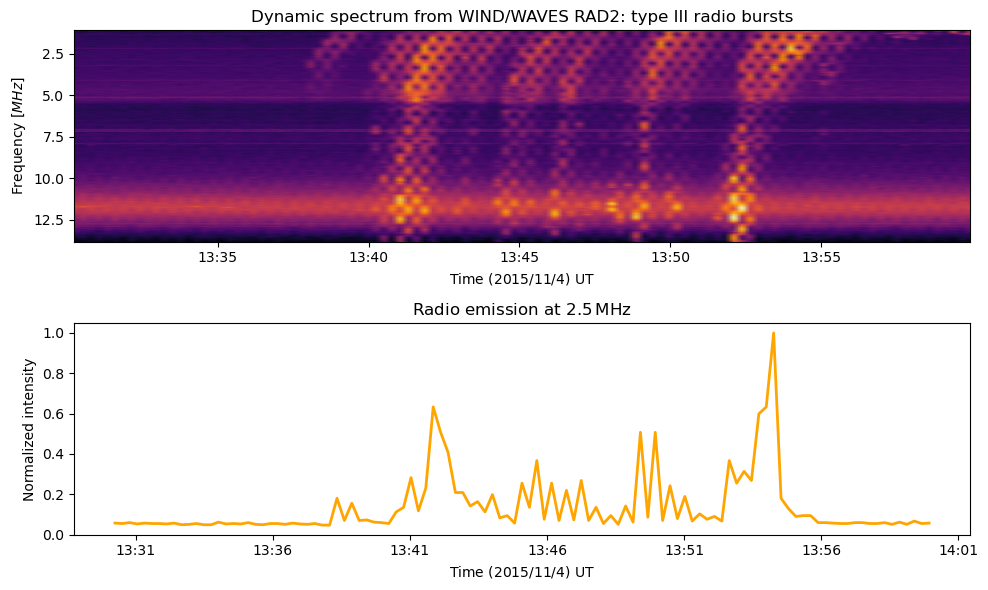

In [72]:
plt.figure(figsize=(10,6))
plt.subplot(211)
plt.pcolormesh(t, freqs, P_log.T, cmap='inferno', shading='gouraud')    
plt.ylim(freqs.min(), freqs.max())
plt.gca().invert_yaxis()       
tcks = [2.5, 5.0, 7.5, 10.0, 12.5]
plt.yticks(tcks)
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.1f"))
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
plt.xlabel(r'Time $(2015/11/4)$ UT')
plt.ylabel(r'Frequency $[MHz]$')
plt.title('Dynamic spectrum from WIND/WAVES RAD2: type III radio bursts')

plt.subplot(212)
idx_2p5 = np.argmin(np.abs(freqs - 2.5))
radio_lc = P[:, idx_2p5]
radio_norm = radio_lc / radio_lc.max()
# radio_norm = (radio_lc - np.nanmin(radio_lc)) / (np.nanmax(radio_lc) - np.nanmin(radio_lc))

plt.plot(t, radio_norm, lw=2, color='orange')
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
plt.xlabel(r'Time $(2015/11/4)$ UT')
plt.xlabel(r'Time $(2015/11/4)$ UT')
plt.ylabel('Normalized intensity')
plt.title(r'Radio emission at $2.5\,\rm MHz$')
plt.tight_layout()
plt.show()

### 4. Hard X-ray (HXR) light curves from RHESSI instrument

---

This data allows for imaging the location of the HXRs produced during the flare.

In [68]:
tr = TimeRange("2015-11-04T13:00", "2015-11-04T14:00")

res = Fido.search(a.Time(tr.start, tr.end), a.Instrument.rhessi,
                  a.Physobs.summary_lightcurve)
files = Fido.fetch(res)

from sunpy.timeseries import TimeSeries  
rhessi = TimeSeries(files) 

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

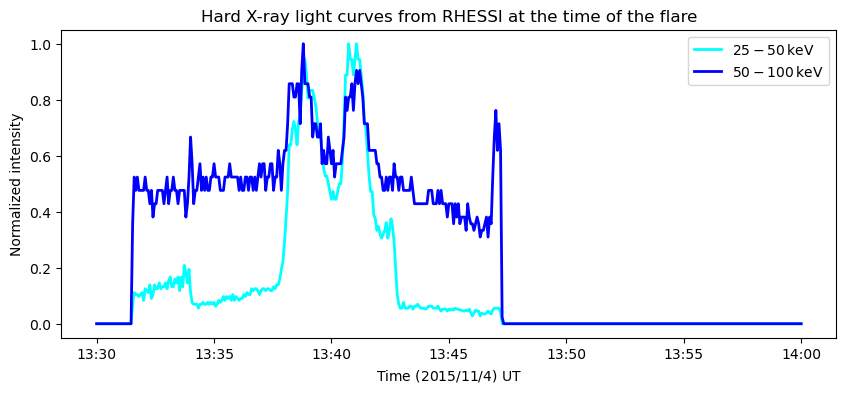

In [20]:
rhessi = rhessi.truncate("2015-11-04T13:30","2015-11-04T14:00")
df = rhessi.to_dataframe()
intensity1 = df['25 - 50 keV']
intensity2 = df['50 - 100 keV']

norm_intensity1 = intensity1 / intensity1.max()
norm_intensity2 = intensity2 / intensity2.max()
# norm_intensity1 = (intensity1 - intensity1.min()) / (intensity1.max() - intensity1.min())
# norm_intensity2 = (intensity2 - intensity2.min()) / (intensity2.max() - intensity2.min())

plt.figure(figsize=(10,4))
plt.plot(norm_intensity1.index, norm_intensity1, c='cyan', lw=2, label=r'$25-50\,\rm keV$')
plt.plot(norm_intensity2.index, norm_intensity2, c='blue', lw=2, label=r'$50-100\,\rm keV$')

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))

plt.xlabel(r'Time $(2015/11/4)$ UT')
plt.ylabel('Normalized intensity')
plt.title(r'Hard X-ray light curves from RHESSI at the time of the flare')
plt.legend()
plt.show()

### 5. Overview of what we have so far

--- 

We show dynamic spectrum from WIND/WAVES RAD2 and multi-wavelength light curves observed 

from a number of instruments.

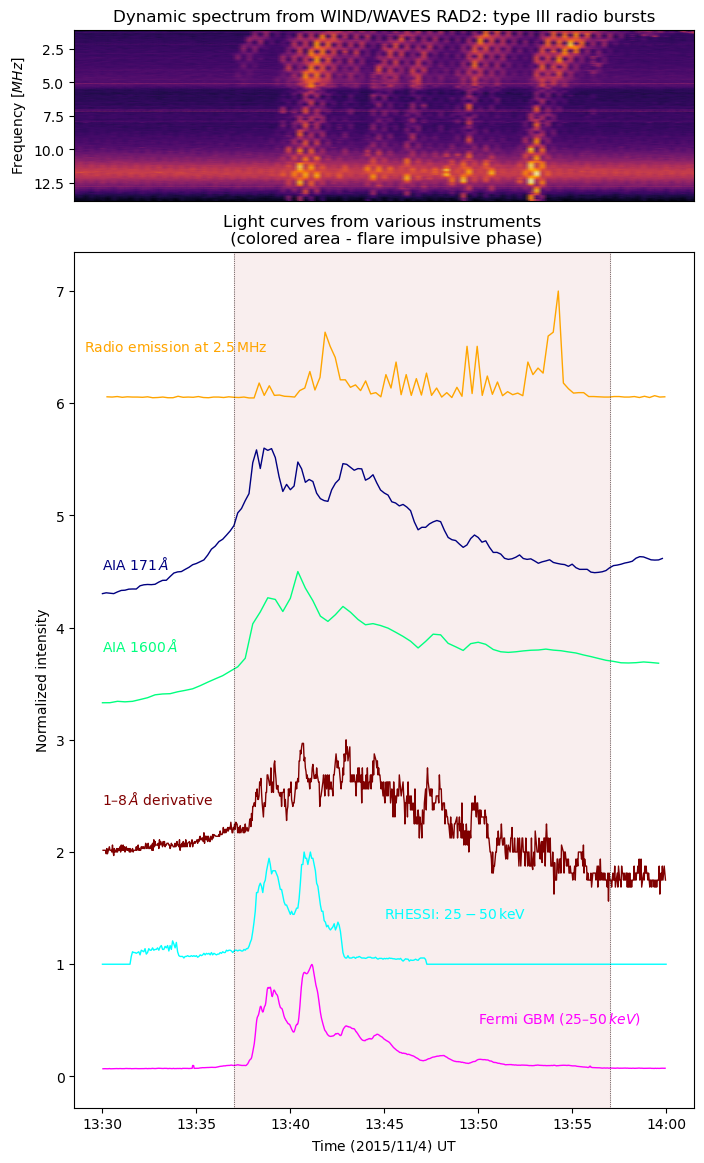

In [78]:
plt.figure(figsize=(8, 14))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 5], hspace=0.1)
plt.subplot(gs[0])
plt.pcolormesh(t, freqs, P_log.T, cmap='inferno', shading='gouraud')  
plt.ylim(freqs.min(), freqs.max())
plt.gca().invert_yaxis()       
tcks = [2.5, 5.0, 7.5, 10.0, 12.5]
plt.yticks(tcks)
plt.xticks([])
ax = plt.gca()
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.1f"))
plt.ylabel(r'Frequency $[MHz]$')
plt.title('Dynamic spectrum from WIND/WAVES RAD2: type III radio bursts')

plt.subplot(gs[1])
aia171 = aia171.truncate("2015-11-04 13:30:00","2015-11-04 14:00:00")
aia1600 = aia1600.truncate("2015-11-04 13:30:00","2015-11-04 14:00:00")

lw=1
plt.plot(smooth_gbm.index, smooth_gbm, c='magenta', lw=lw)
plt.plot(norm_intensity1.index, norm_intensity1+1, c='cyan', lw=lw)
plt.plot(dint_dt_norm.index, dint_dt_norm+2, c='maroon', lw=lw)
plt.plot(aia1600.index, aia1600*10-5.5, c='springgreen', lw=lw)
plt.plot(aia171.index, aia171*7, c='navy', lw=lw)
plt.plot(t, radio_norm+6, color='orange', lw=lw)  
start = pd.to_datetime("2015-11-04 13:37:00")
end   = pd.to_datetime("2015-11-04 13:57:00")
plt.axvspan(start, end, color='indianred', alpha=0.1)

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
plt.xlabel(r'Time $(2015/11/4)$ UT')
plt.ylabel('Normalized intensity')
plt.axvline(pd.Timestamp("2015-11-04 13:37:00"), linestyle=':', lw=0.5, c='black')
plt.axvline(pd.Timestamp("2015-11-04 13:57:00"), linestyle=':', lw=0.5, c='black')
plt.title('Light curves from various instruments \n (colored area - flare impulsive phase)')

ax = plt.gca()
ymin, ymax = ax.get_ylim()
yoff = (ymax - ymin) * 0.05
plt.text(pd.Timestamp("2015-11-04 13:50:00"), gbm.iloc[0] + 1 +  yoff,
         r'Fermi GBM ($25–50\,keV$)', color='magenta', va='bottom')
plt.text(pd.Timestamp("2015-11-04 13:45:00"), norm_intensity1.iloc[0] + 1 + yoff,
         r'RHESSI: $25-50\,\rm keV$', color='cyan', va='bottom')
plt.text(pd.Timestamp("2015-11-04 13:30:00"), dint_dt_norm.iloc[0] + 2 + yoff,
         r'$1–8\,\AA$ derivative', color='maroon', va='bottom')
plt.text(pd.Timestamp("2015-11-04 13:30:00"), aia1600.iloc[0] + 2.5 + yoff,
         r'AIA $1600\,\AA$', color='springgreen', va='bottom')
plt.text(pd.Timestamp("2015-11-04 13:30:00"), aia171.iloc[0] + 3.5 + yoff,
         r'AIA $171\,\AA$', color='navy', va='bottom')
plt.text(pd.Timestamp("2015-11-04 13:29:00"), radio_norm[0] + 6 + yoff,
         r'Radio emission at $2.5\,\rm MHz$', color='orange', va='bottom')
plt.show()

### 6. Attempt to perform background substraction - one example

--- 

Here, we try to isolate the QPPs. We try to exclude the shorter timescale variation of the QPPs.

We perform the background substraction only for SXR derivative. Our method is improvisation for now.

In [22]:
goes_derv = dint_dt_norm
goes_derv = goes_derv.truncate("2015-11-04T13:34","2015-11-04T13:52")
t = (goes_derv.index - goes_derv.index[0]).total_seconds()
y = goes_derv.values
n = len(y)
idx = np.arange(28, n-28, 28)
knots = t[idx]
spline = UnivariateSpline(t, y, k=3, s=0.015*len(y))
background = spline(t)
detrended = y - background

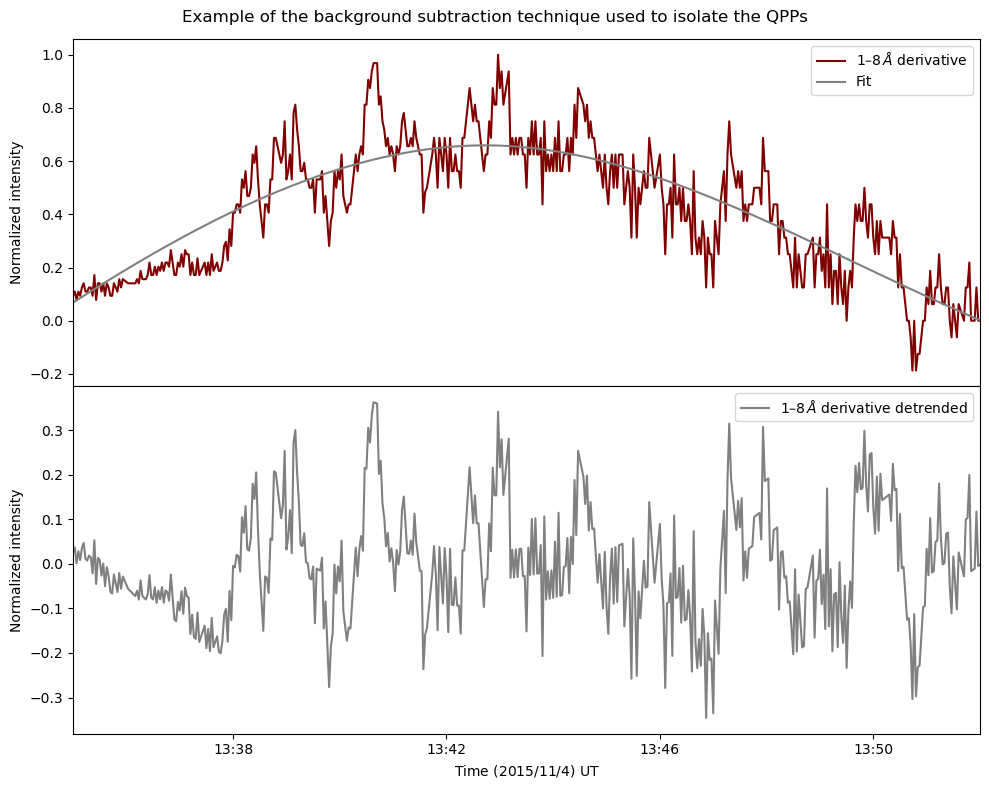

In [23]:
plt.figure(figsize=(10,8))
plt.subplot(211)
plt.plot(goes_derv.index, y, c='maroon', label=r'$1–8\,\AA$ derivative')
plt.plot(goes_derv.index, background, c='grey', label='Fit')
plt.ylabel('Normalized intensity')
plt.xticks([])
plt.xlim(['2015-11-04 13:35','2015-11-04 13:52'])
plt.legend()
plt.subplot(212)
plt.plot(goes_derv.index, detrended, color='grey', label=r'$1–8\,\AA$ derivative detrended')
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=4))
plt.xlim(['2015-11-04 13:35','2015-11-04 13:52'])
plt.xlabel(r'Time $(2015/11/4)$ UT')
plt.ylabel('Normalized intensity')
plt.legend()
plt.suptitle('Example of the background subtraction technique used to isolate the QPPs')
plt.tight_layout()
plt.subplots_adjust(hspace=0.0)
plt.show()

### 7. Determination of the periodicities - wavelet

---

#### Here, we perform detailed wavelet analysis of multiwavelength light curves. 

In [287]:
from waveletFunctions import wavelet, wave_signif
import waveletFunctions as wf # for insight
help(wf.wavelet)

Help on function wavelet in module waveletFunctions:

wavelet(Y, dt, pad=0, dj=-1, s0=-1, J1=-1, mother=-1, param=-1, freq=None)



In [282]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import LSQUnivariateSpline
from scipy.ndimage import label as nd_label
from scipy.signal import savgol_filter, butter, filtfilt
from waveletFunctions import wavelet, wave_signif

def wavelet_analysis(series: pd.Series,
                           dj: float = 0.25,
                           s0_factor: float = 2.0,
                           pad: int = 2,
                           k0: float = 6.0,
                           samples_between_knots: int = 28,
                           detrend: bool = True,
                           detrend_method: str = "spline",
                           period_min: float = 100.0,
                           period_max: float = 350.0,
                           peak_method: str = "ridge",
                           min_ratio: float = 1.0,
                           radio: bool = False):
   
    if isinstance(series, pd.DataFrame):
        if series.shape[1] != 1:
            raise ValueError("Input must be a single column")
        y = series.iloc[:, 0].dropna().sort_index()
    else:
        y = series.dropna().sort_index()
    if not isinstance(y.index, pd.DatetimeIndex):
        raise ValueError("Index must be DateTimeIndex")

    if radio:
        period_min, period_max = 150.0, 300.0
        min_ratio = max(min_ratio, 1.5)

    t = (y.index - y.index[0]).total_seconds().values
    dt = np.median(np.diff(t))
    if dt <= 0:
        raise ValueError("Non-positive time step detected.")
    N = len(y)
    s0 = s0_factor * dt
    J1 = int(np.log2(N * dt / s0) / dj)

    if detrend:
        if detrend_method == "spline":
            knots = np.arange(samples_between_knots, N, samples_between_knots)
            if len(knots) < 2:
                raise ValueError("Insufficient knot points for spline.")
            spline = LSQUnivariateSpline(t, y.values, t[knots], k=3)
            proc = y.values - spline(t)
        elif detrend_method == "savgol":
            window = int(400.0 / dt)
            if window % 2 == 0:
                window += 1
            baseline = savgol_filter(y.values, window_length=window, polyorder=3, mode='interp')
            proc = y.values - baseline
        else:
            raise ValueError("Choose 'spline' or 'savgol' for detrend_method")
        method_label = "Detrended"
    else:
      
        low, high = 1.0/period_max, 1.0/period_min
        fs = 1.0/dt
        nyq = fs/2.0
        w_low, w_high = low/nyq, high/nyq
        if 0 < w_low < w_high < 1:
            b, a = butter(2, [w_low, w_high], btype='bandpass')
            proc = filtfilt(b, a, y.values)
        else:
            proc = y.values.copy()
        method_label = "Bandpass Filtered"

    norm_det = proc / np.max(np.abs(proc))

    wave, period, scale, coi = wavelet(proc, dt, pad=pad, dj=dj,
                                      s0=s0, J1=J1, mother='MORLET', param=k0)
    power = np.abs(wave)**2

    var = np.var(proc, ddof=1)
    lag1 = np.corrcoef(proc[:-1], proc[1:])[0,1]
    sig_local = wave_signif(var, dt, scale, sigtest=0, lag1=lag1, mother='MORLET')
    sig_global = wave_signif(var, dt, scale, sigtest=1, lag1=lag1,
                             dof=np.maximum(1, N-scale), mother='MORLET')

    band = (period>=period_min)&(period<=period_max)
    global_ws = power.mean(axis=1)
    mask = band & (global_ws>sig_local*min_ratio)
    labeled, nregions = nd_label(mask)
    if nregions==0:
        raise ValueError(f"No significant QPP in {period_min}-{period_max}s band")
    best_period = None
    if peak_method=="ridge":
        best_len=-1
        for idx in np.where(mask)[0]:
            length=np.sum(power[idx]>sig_local[idx])
            if length>best_len:
                best_len,length, best_period = length,length,period[idx]
    elif peak_method=="ratio_ridge":
        best_score=-np.inf
        for idx in np.where(mask)[0]:
            ratio=global_ws[idx]/sig_local[idx]
            if ratio<min_ratio: continue
            length=np.sum(power[idx]>sig_local[idx])
            score=ratio*length
            if score>best_score:
                best_score, best_period=score,period[idx]
    else:
        raise ValueError("peak_method must be 'ridge' or 'ratio_ridge'")
    if best_period is None:
        raise ValueError("No period selected")
    sel=(period>=(best_period*(1-dj)))&(period<=(best_period*(1+dj)))&mask
    left=period[sel].min() if sel.any() else best_period
    right=period[sel].max() if sel.any() else best_period
    err_low=best_period-left
    err_high=right-best_period

    fig=plt.figure(figsize=(12,8))
    gs=fig.add_gridspec(2,4,height_ratios=[2,3],width_ratios=[1,1,1,1],
                        hspace=0.1,wspace=0.2)

    ax_ts=fig.add_subplot(gs[0,:3])
    ax_ts.plot(t,norm_det,'k',lw=1)
    ax_ts.set_xlim(t.min(),t.max())
    ax_ts.set_ylim((-1, 1) if detrend else (norm_det.min(), norm_det.max()))
    ax_ts.set_ylabel('Normalized Intensity')
    ax_ts.set_title(r'Morlet wavelet analysis: WIND ($2.5\,MHz$)')
    ax_ts.xaxis.set_visible(False)
 
    ax_box=fig.add_subplot(gs[0,3])
    ax_box.axis('off')
    ax_box.text(0.5,0.5,rf"$P={best_period:.1f}^{{+{err_high:.1f}}}_{{-{err_low:.1f}}}\,s$",
                ha='center',va='center',transform=ax_box.transAxes,
                fontsize=12,bbox=dict(boxstyle='round,pad=0.3',edgecolor='red',
                                     facecolor='indianred',alpha=0.3,linewidth=2))

    ax_wps = fig.add_subplot(gs[1,:3])
    ax_wps.set_facecolor('black')
    T,Pm = np.meshgrid(t,period)
    ax_wps.contourf(T,Pm,power,levels=10,cmap='viridis',extend='both')
    ax_wps.contour(T,Pm,power/sig_local[:,None],levels=[1],colors='orange',linewidths=1)
    ax_wps.plot(t,coi,'w-',lw=1.5)
    ax_wps.fill_between(t,coi,period.max(),facecolor='none',edgecolor='white',alpha=0.3)
    ax_wps.axhline(best_period,color='white',ls='--',lw=1)
    ax_wps.set_xlabel("Time (s)")
    ax_wps.set_ylabel("Period (s)")
    ax_wps.set_yscale('log')
    ymin=period.min()
    ymax=period.max()
    ax_wps.set_ylim(ymin,ymax)
    yticks=[ymin,100,1000]
    ax_wps.set_yticks(yticks)
    ax_wps.set_xlim(t.min(),t.max())

    ax_gws=fig.add_subplot(gs[1,3],sharey=ax_wps)
    norm_ws=global_ws/np.nanmax(global_ws)
    norm_sig=(sig_local if period_min is not None else sig_global)/np.nanmax(global_ws)
    ax_gws.plot(norm_ws,period,'k')
    ax_gws.plot(norm_sig,period,'k--', label=r'$95\%$ significance')
    ax_gws.axhline(best_period,color='red',ls='--',lw=1)
    ax_gws.set_xscale('log')
    ax_gws.set_xlim(0.01,1)
    ax_gws.set_xlabel("Normalized Power")
    ax_gws.yaxis.set_visible(False)
    ax_gws.set_title('Global spectrum')
    ax_gws.legend()

    return best_period, err_low, err_high, fig

#### If we perform wavelet analysis with detrending, then we need exact time period

#### $t\in(13:34,\,13:54)\,\rm UT$. The same analysis is performed for the data without

#### detrending, for time period $t\in(13:30,\,14:00)\,\rm UT$.

In [229]:
t0_dt, t1_dt = "2015-11-04 13:34:00", "2015-11-04 13:54:00"
t0_nd, t1_nd = "2015-11-04 13:30:00", "2015-11-04 14:00:00"

--- 

#### AIA $171\,\rm Å$:

#### upper - wavelet analysis with detrending

#### lower - wavelet analysis without detrending

---

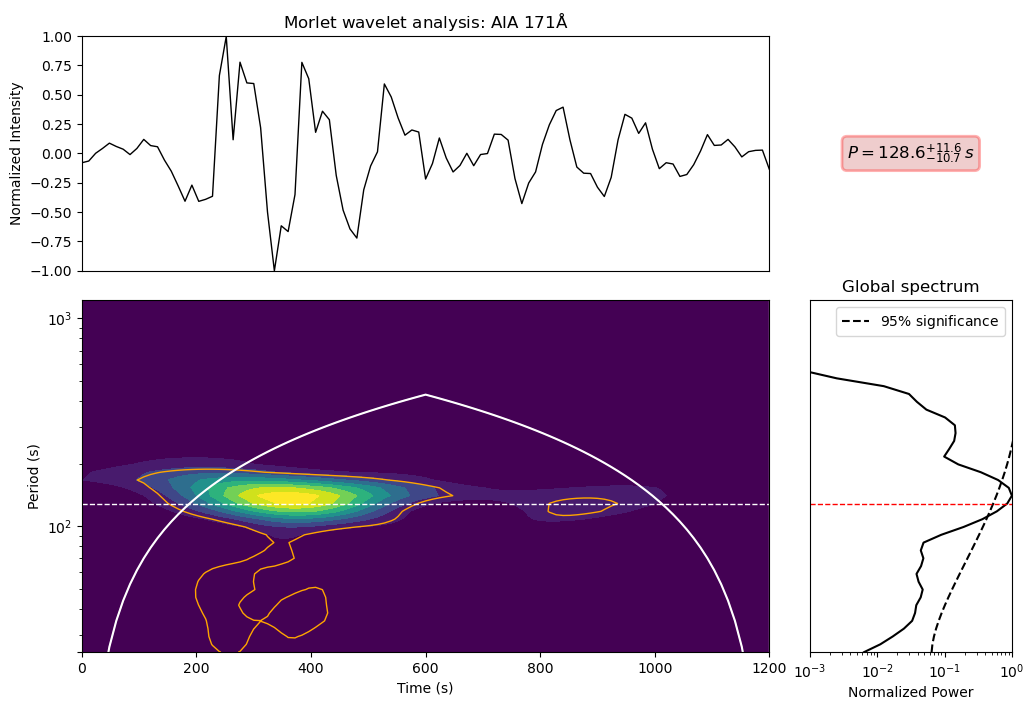

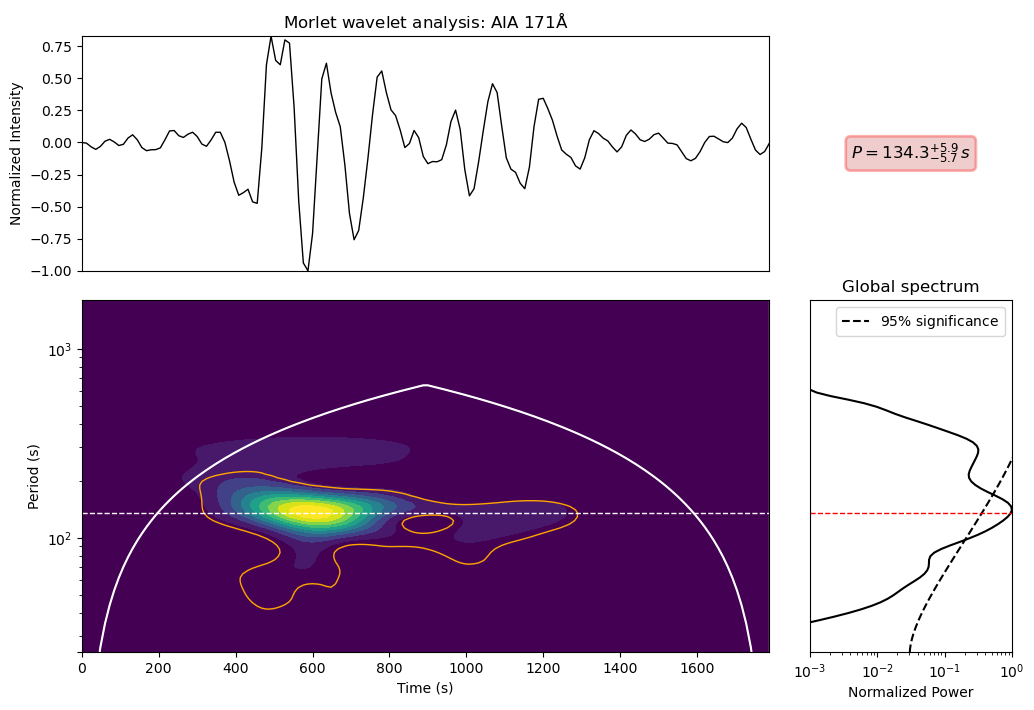

In [245]:
aia171     = pd.read_pickle('norm171.pkl')
aia171 = aia171.loc[t0_dt:t1_dt]

P0, err_low, err_high, fig = wavelet_analysis(aia171, dj=0.125,
                                detrend=True, peak_method='ridge',
                                detrend_method='savgol')

aia171     = pd.read_pickle('norm171.pkl')
aia171 = aia171.loc[t0_nd:t1_nd]

P0, err_low, err_high, fig = wavelet_analysis(aia171, dj=0.0625,
                                detrend=False, peak_method='ridge')

--- 

#### AIA $1600\,\rm Å$:

#### upper - wavelet analysis with detrending

#### lower - wavelet analysis without detrending

---

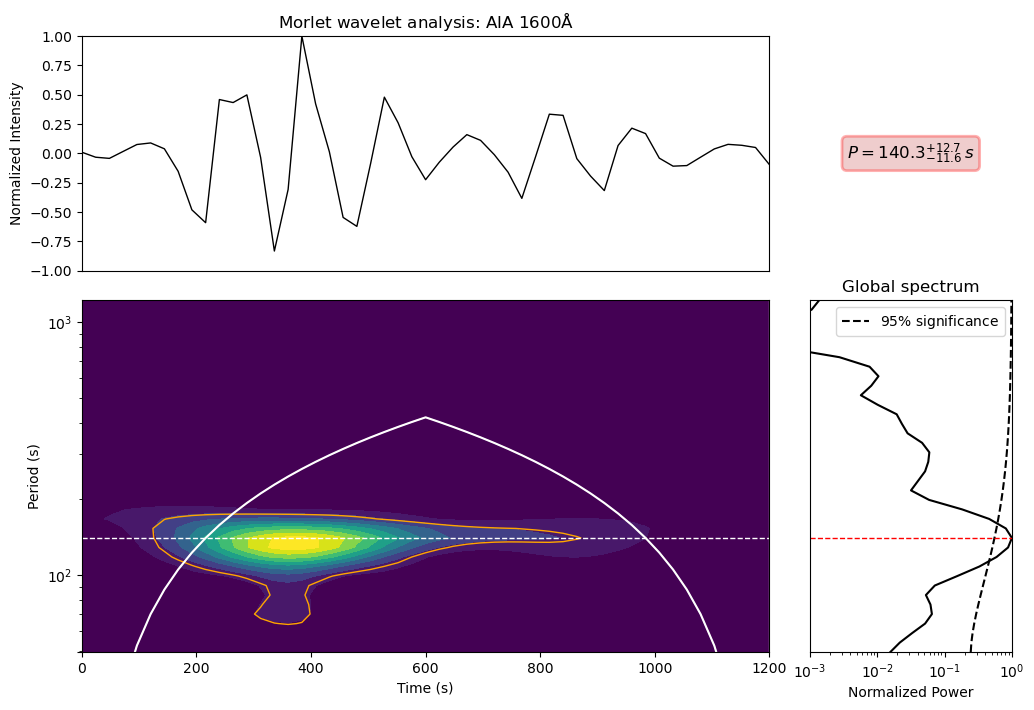

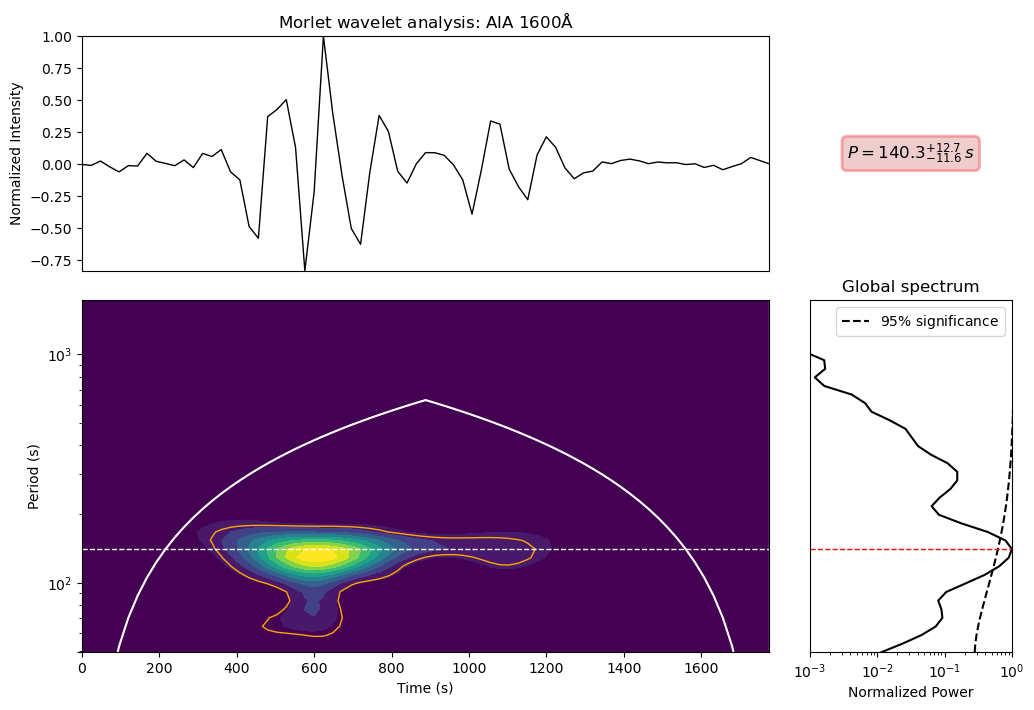

In [256]:
aia1600 = pd.read_pickle('norm1600.pkl')
aia1600 = aia1600.loc[t0_dt:t1_dt]

P0, err_low, err_high, fig = wavelet_analysis(aia1600, dj=0.125,
                                detrend=True, peak_method='ridge',
                                detrend_method='savgol')

aia1600 = pd.read_pickle('norm1600.pkl')
aia1600 = aia1600.loc[t0_nd:t1_nd]

P0, err_low, err_high, fig = wavelet_analysis(aia1600, dj=0.125,
                                detrend=False, peak_method='ridge')

--- 

#### FERMI GBM $25-50\,\rm keV$:

#### upper - wavelet analysis with detrending

#### lower - wavelet analysis without detrending

---

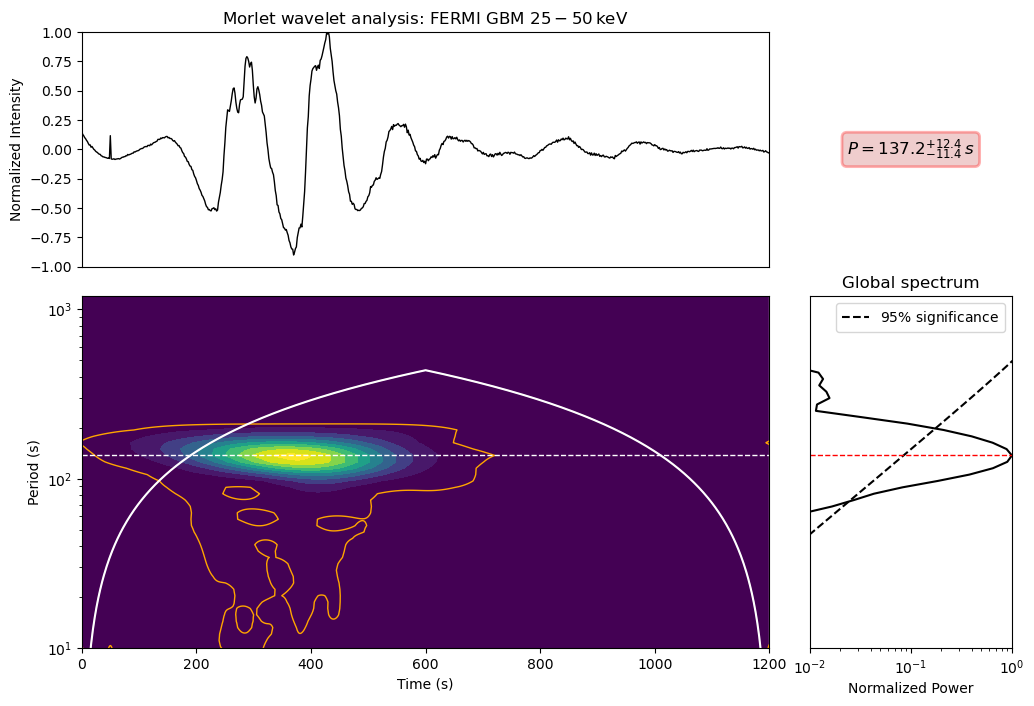

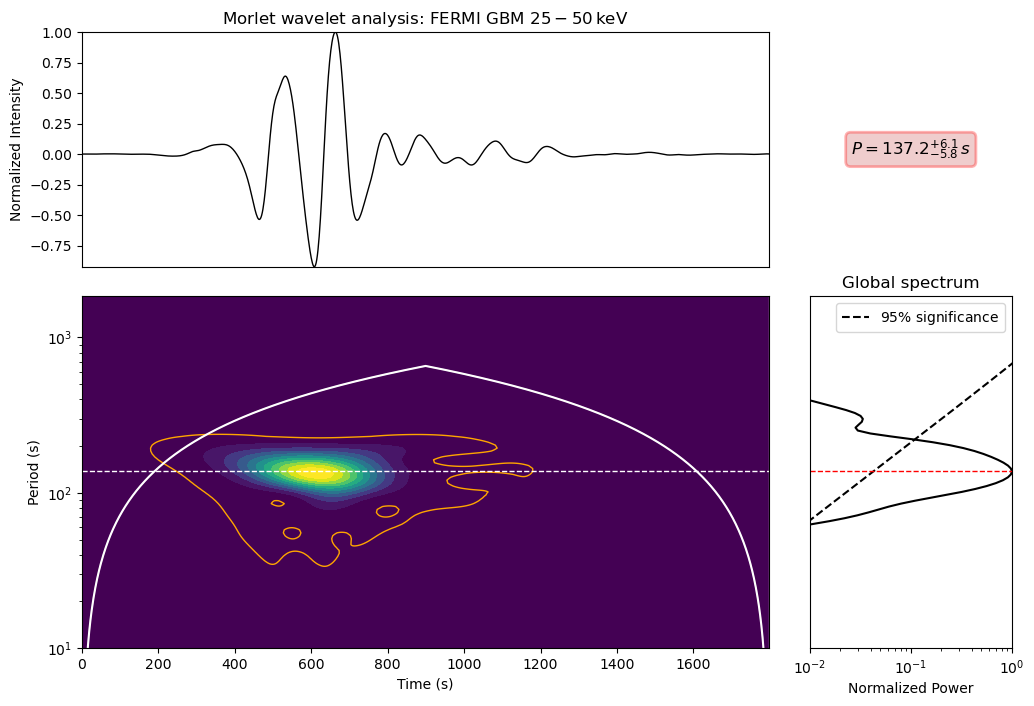

In [275]:
fermi = norm_gbm
fermi = norm_gbm.loc[t0_dt:t1_dt]

P0, err_low, err_high, fig = wavelet_analysis(fermi, dj=0.125,
                                detrend=True, peak_method='ridge',
                                detrend_method='savgol')

fermi = norm_gbm
fermi = norm_gbm.loc[t0_nd:t1_nd]

P0, err_low, err_high, fig = wavelet_analysis(fermi, dj=0.0625,
                                detrend=False, peak_method='ratio_ridge')

--- 

#### GOES derivative ($1-8\,\rm Å$):

#### upper - wavelet analysis with detrending

#### lower - wavelet analysis without detrending

---

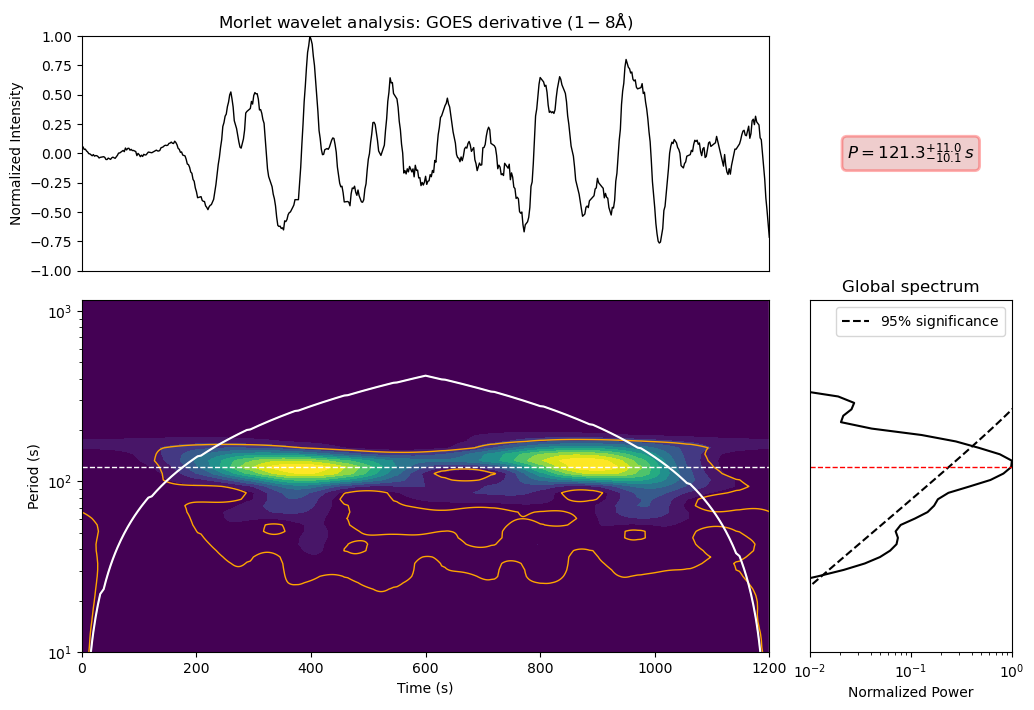

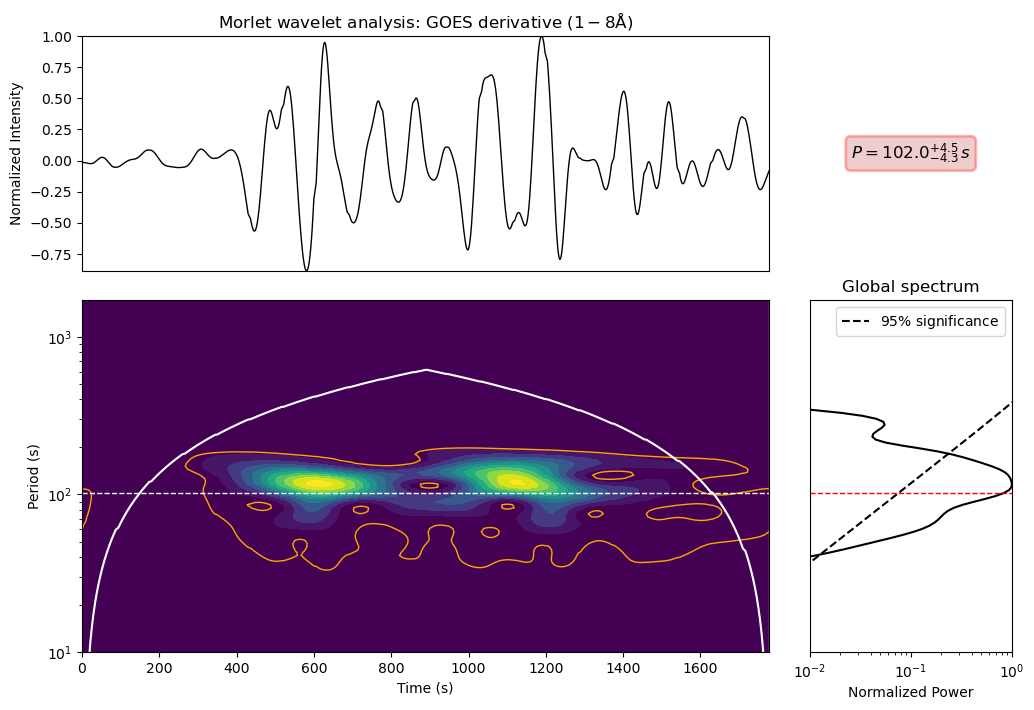

In [268]:
goes = smooth_goes_derv
goes = goes.loc[t0_dt:t1_dt]

P0, err_low, err_high, fig = wavelet_analysis(goes, dj=0.125,
                                detrend=True, peak_method='ridge',
                                detrend_method='savgol')

goes = smooth_goes_derv
goes = goes.loc[t0_nd:t1_nd]

P0, err_low, err_high, fig = wavelet_analysis(goes, dj=0.0625,
                                detrend=False, peak_method='ratio_ridge')

--- 

#### WIND $2.5\,\rm MHz$:

#### upper - wavelet analysis with detrending

#### lower - wavelet analysis without detrending

---

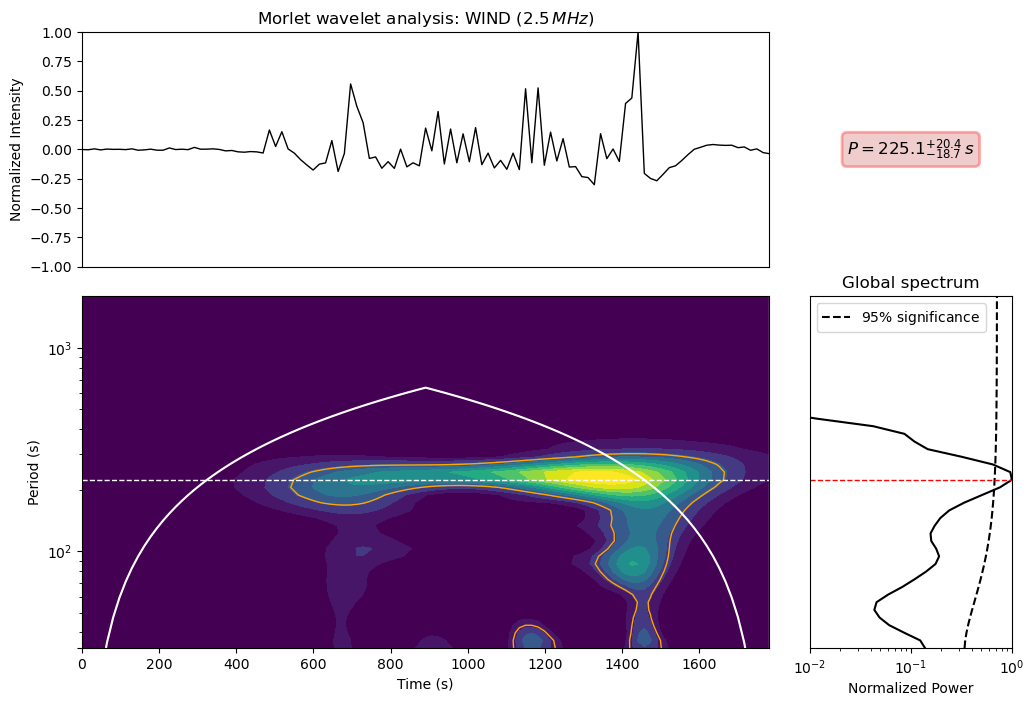

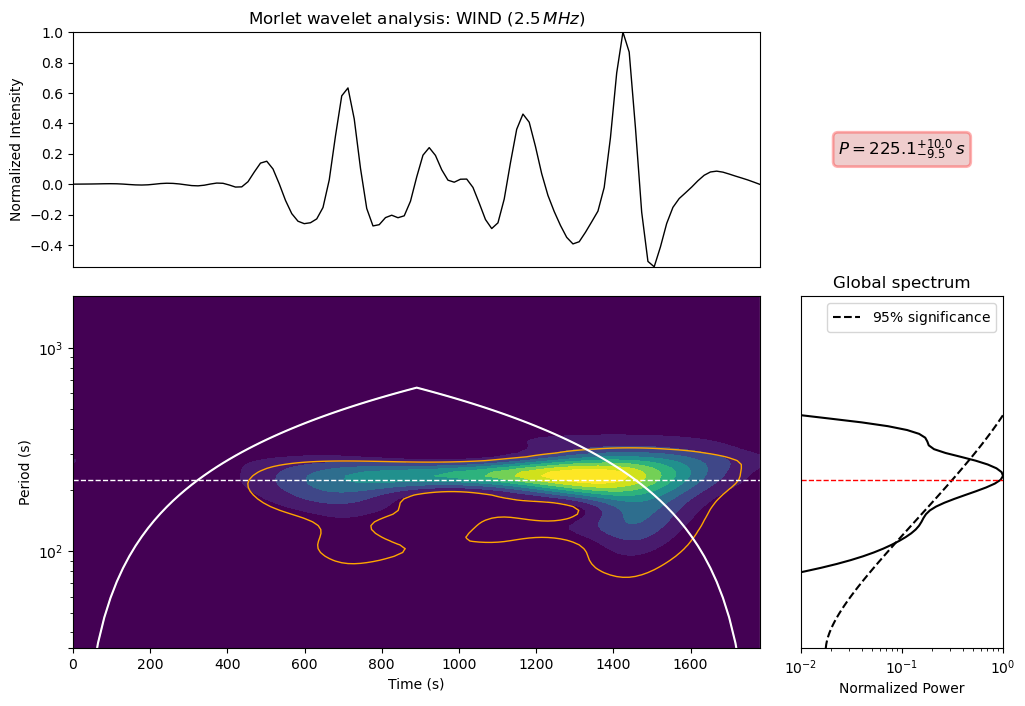

In [286]:
radio_lc    = psd[mask, idx_2p5] 
radio_norm  = radio_lc / radio_lc.max()
radio_series = pd.Series(radio_norm, index=radio_times)

P0, err_low, err_high, fig = wavelet_analysis(radio_series, dj=0.125,
                                detrend=True, peak_method='ridge',
                                detrend_method='savgol')

P0, err_low, err_high, fig = wavelet_analysis(radio_series, dj=0.0625,
                                detrend=False, peak_method='ratio_ridge')

### 8. Determination of the periodicities - manually 
---

#### Here, we estimate them manually by visually identifying peaks.